This code computes the probability of Schwinger pair production using the method in:

*Momentum correlation in pair production by spacetime dependent fields from scattered wave functions*

arXiv:2509.17770

G. Torgrimsson

# Import

diffrax contains the ODE solver for solving the Dirac equation on T4 GPU

In [ ]:
%%capture output
%pip install diffrax

In [ ]:
import jax.numpy as np
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, PIDController
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import make_interp_spline
from tqdm import tqdm

# Define field and discretization

We assume a gauge field with ${\bf A}=0$ and $A_0(t,x,y)$. The field and the scattered wave function should be contained in $-z_b<x,y<z_b$. $n_z$ is the number of points in the $x$ and $y$ directions. $n_k$ ($\geq n_z$) is the number of points in the Fourier space. Both $n_z$ and $n_k$ should be odd.   

In [ ]:
gamma=1
E0=1/3
omega=gamma*E0
kappa=gamma*E0

zb=22
nz=201
nk=401

tin=-10
tout=10

chop=1e-7

def A0(t,x,y):
  return (E0/kappa)*np.exp(-(omega*t)**2-kappa*kappa*(x**2+y**2))

def At(t):
  return A0(t,0,0)/A0(0,0,0)

# Definitions

2D spinors:

In [ ]:
def u1(P1,P2):
  P0=np.sqrt(1+P1*P1+P2*P2)
  return 0.j+(1+P0)/np.sqrt(2*P0*(1+P0))

def u2(P1,P2):
  P0=np.sqrt(1+P1*P1+P2*P2)
  return (-P1-1j*P2)/np.sqrt(2*P0*(1+P0))

def v1(P1,P2):
  P0=np.sqrt(1+P1*P1+P2*P2)
  return np.where(P0==1.,0.+0.j,(-P1+1j*P2)*np.sqrt((P0-1)/(2*P0*(P1*P1+P2*P2))))

def v2(P1,P2):
  P0=np.sqrt(1+P1*P1+P2*P2)
  return np.where(P0==1.,1.+0.j,0.j+np.sqrt((P1*P1+P2*P2)/(2*P0*(P0-1))))

def u2D(P1,P2):
  return [u1(P1,P2),u2(P1,P2)]

def v2D(P1,P2):
  return [v1(P1,P2),v2(P1,P2)]

Grid definitions:

In [ ]:
z0=-zb
z1=zb
dz=(z1-z0)/(nz-1)
zGrid=np.linspace(z0,z1,nz)
dk=2*np.pi/(nk*dz)
kMax=dk*(nk-1)/2
kGrid=dk*np.linspace(-(nk-1)/2,(nk-1)/2,nk)
kFFT=2*np.pi*np.fft.fftfreq(nk,dz)
kFFTT=kFFT.reshape(-1,1)
nPad=(nk-nz)//2

psiOut=np.zeros(2*2*nz*nz,dtype=np.float32)

X,Y=np.meshgrid(zGrid,zGrid,indexing='ij')
K1,K2=np.meshgrid(kFFT,kFFT,indexing='ij')

AzGrid=A0(0,X,Y)
AzGrid=np.where(np.abs(AzGrid)<chop,0.+0.j,AzGrid)

The spatial derivatives, $\partial_x$ and $\partial_y$, are calculated by Fourier transforming, multiplying by $k_1$ or $k_2$, and then Fourier transforming back to $x$ and $y$.  

In [ ]:
def fDer(phi):
  global xDer, yDer

  der=np.pad(phi,nPad)
  der=np.fft.ifft2(der)

  xDer=-1j*kFFTT*der
  xDer=np.fft.fft2(xDer)
  xDer=xDer[nPad:-nPad,nPad:-nPad]
  xDer=np.where(np.abs(xDer)<chop,0.+0.j,xDer)

  yDer=-1j*kFFT*der
  yDer=np.fft.fft2(yDer)
  yDer=yDer[nPad:-nPad,nPad:-nPad]
  yDer=np.where(np.abs(yDer)<chop,0.+0.j,yDer)

Constructing $d\psi$ in the Dirac equation, $\partial_t\psi_\text{scat.}=d\psi$.

In [ ]:
def makeDer(P1,P2,sign):
  P0=np.sqrt(1+P1*P1+P2*P2)

  if sign==1:
    uOut1,uOut2=u2D(P1,P2)
  elif sign==-1:
    uOut1,uOut2=v2D(P1,P2)

  inho=A0(0,X,Y)*np.exp(-1j*sign*(P1*X+P2*Y))
  inho=np.where(np.abs(inho)<chop,0.+0.j,inho)

  def dPsi(mt,y,args):
    t=-mt
    real,imag=np.split(y,2)
    phi=real+1j*imag
    phiR=phi.reshape((2,nz,nz))
    phi1=phiR[0]
    phi2=phiR[1]
    fDer(phi2)
    e1=(xDer-1j*yDer+1j*phi1+1j*At(t)*(AzGrid*phi1+uOut1*np.exp(-1j*sign*P0*t)*inho))
    fDer(phi1)
    e2=(xDer+1j*yDer-1j*phi2+1j*At(t)*(AzGrid*phi2+uOut2*np.exp(-1j*sign*P0*t)*inho))
    phiR=np.concatenate((e1,e2))
    phiR=np.where(np.abs(phiR)<chop,0.+0.j,phiR)
    phiR=np.concatenate([np.real(phiR),np.imag(phiR)])
    return phiR.ravel()

  return dPsi

In [ ]:
u1FFT=u1(K1,-K2)*np.exp(1j*np.sqrt(1+K1*K1+K2*K2)*tin)
u2FFT=u2(K1,-K2)*np.exp(1j*np.sqrt(1+K1*K1+K2*K2)*tin)
v1FFT=v1(-K1,K2)*np.exp(-1j*np.sqrt(1+K1*K1+K2*K2)*tin)
v2FFT=v2(-K1,K2)*np.exp(-1j*np.sqrt(1+K1*K1+K2*K2)*tin)

Project $\psi_\text{scat.}=\Delta U$ and $\psi_\text{scat.}=\Delta V$ onto in states: $(U_{\rm in}|\Delta U)$, $(V_{\rm in}|\Delta U)$, $(U_{\rm in}|\Delta V)$ and $(V_{\rm in}|\Delta V)$.

In [ ]:
def projectU():
  global UU
  global VU

  f1=np.pad(Usol[0],nPad)
  f2=np.pad(Usol[1],nPad)
  f1=np.fft.ifft2(f1)
  f2=np.fft.ifft2(f2)

  UU=u1FFT*f1+u2FFT*f2
  UU=np.fft.fft2(UU)
  UU=UU[nPad:-nPad,nPad:-nPad]

  VU=v1FFT*f1+v2FFT*f2
  VU=np.fft.fft2(VU)
  VU=VU[nPad:-nPad,nPad:-nPad]

def projectV():
  global UV
  global VV

  f1=np.pad(Vsol[0],nPad)
  f2=np.pad(Vsol[1],nPad)
  f1=np.fft.ifft2(f1)
  f2=np.fft.ifft2(f2)

  UV=u1FFT*f1+u2FFT*f2
  UV=np.fft.fft2(UV)
  UV=UV[nPad:-nPad,nPad:-nPad]

  VV=v1FFT*f1+v2FFT*f2
  VV=np.fft.fft2(VV)
  VV=VV[nPad:-nPad,nPad:-nPad]

Solve the Dirac equation, project onto in states, and then perform the integrals in

\begin{equation}
N_{1\text{vers1}}=\big|{}_m(U_\infty|\Delta V)_n+{}_m(\Delta U|U_\infty)(U_\infty|\Delta V)_n\big|_{t=t_{\rm in}}^2
\end{equation}
\begin{equation}
N_{1\text{vers2}}=\big|{}_m(\Delta U|V_\infty)_n+{}_m(\Delta U|V_\infty)(V_\infty|\Delta V)_n\big|_{t=t_{\rm in}}^2
\end{equation}

We should find $N_{1\text{vers1}}=N_{1\text{vers2}}$ to within the numerical precision.

In [ ]:
def doAll(P1,P2,PP1,PP2):
  global Usol, Vsol, UU, VU, UV, VV, UUUV, UVdelta, UVVV, VUdelta, N1vers1, N1vers2

  solver = Dopri5()
  controller = PIDController(rtol=1e-5, atol=1e-10)

  UdPsi=makeDer(P1,P2,1)
  term = ODETerm(UdPsi)
  solutionU = diffeqsolve(term,solver,t0=tin,t1=tout,dt0=1e-3,y0=psiOut,
    stepsize_controller=controller,saveat=SaveAt(t1=True)
  )

  Usolr,Usoli=np.split(solutionU.ys[0],2)
  Usol=Usolr+1j*Usoli
  Usol=Usol.reshape((2,nz,nz))

  VdPsi=makeDer(PP1,PP2,-1)
  term = ODETerm(VdPsi)
  solutionV = diffeqsolve(term,solver,t0=tin,t1=tout,dt0=1e-3,y0=psiOut,
    stepsize_controller=controller,saveat=SaveAt(t1=True)
  )

  Vsolr,Vsoli=np.split(solutionV.ys[0],2)
  Vsol=Vsolr+1j*Vsoli
  Vsol=Vsol.reshape((2,nz,nz))

  projectU()
  projectV()

  UUUVgrand=np.conjugate(UU)*UV
  UUUV=simpson(UUUVgrand,zGrid,axis=1)
  UUUV=simpson(UUUV,zGrid)

  UVdeltaGrand=np.exp(1j*(P1*X+P2*Y))*UV
  UVdelta=simpson(UVdeltaGrand,zGrid,axis=1)
  UVdelta=simpson(UVdelta,zGrid)

  UVVVgrand=np.conjugate(VU)*VV
  UVVV=simpson(UVVVgrand,zGrid,axis=1)
  UVVV=simpson(UVVV,zGrid)

  VUdeltaGrand=np.exp(1j*(PP1*X+PP2*Y))*np.conjugate(VU)
  VUdelta=simpson(VUdeltaGrand,zGrid,axis=1)
  VUdelta=simpson(VUdelta,zGrid)

  N1vers1=np.abs(UVdelta+UUUV)**2
  N1vers2=np.abs(VUdelta+UVVV)**2

# Calculation

Check that dz and dk are small enough, and that kMax is large enough.

In [ ]:
[kappa*dz,dk,kMax]

[0.07333333333333333, 0.07122177858965752, 14.244355717931503]

Example:

In [ ]:
p1=-.35; p2=0.; pp1=-p1; pp2=-p2

In [ ]:
doAll(p1,p2,pp1,pp2)

In [ ]:
[N1vers1,N1vers2,N1vers1/N1vers2-1]

[Array(0.00219078, dtype=float32),
 Array(0.00219016, dtype=float32),
 Array(0.00028121, dtype=float32)]

OK, N1vers1 and N1vers2 agree. Could also check that different values of tin gives the same result.

Make a 1D cross section in the 4D momentum space:

In [ ]:
pmin=0.; pmax=1.; dp=(pmax-pmin)/20.
pList=np.arange(dp,pmax+dp,dp)

In [ ]:
tab1=[0 for _ in pList]
tab2=[0 for _ in pList]

In [ ]:
ip=0
for p in tqdm(pList):
  p1=-p; p2=0; pp1=-p1; pp2=0
  doAll(p1,p2,pp1,pp2)
  tab1[ip]=N1vers1
  tab2[ip]=N1vers2
  ip=ip+1

100%|██████████| 20/20 [02:25<00:00,  7.26s/it]


Much faster than a CPU code!

In [ ]:
tab1=np.array(tab1)
tab2=np.array(tab2)

In [ ]:
tab1/tab2-1

Array([-0.00320643, -0.00170785, -0.00043529, -0.00018853, -0.00063884,
       -0.00074017,  0.00024617,  0.00118303,  0.0001173 , -0.0017789 ,
       -0.00117856,  0.00229037,  0.00298083, -0.00157654, -0.00254256,
        0.00965905,  0.01774836,  0.00384831, -0.00652051,  0.01952314],      dtype=float32)

Make a smooth interpolation function for plotting:

In [ ]:
inter1=make_interp_spline(pList,2*tab1/((2*np.pi)**5), k=3)
inter2=make_interp_spline(pList,2*tab2/((2*np.pi)**5), k=3)

pDense=np.linspace(pList.min(), pList.max(), 100)
dense1=inter1(pDense)
dense2=inter2(pDense)

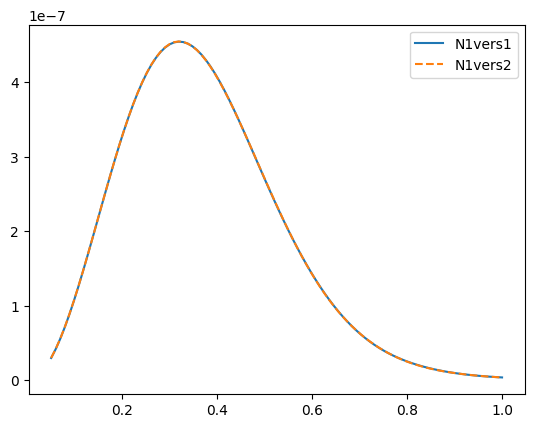

In [ ]:
plt.plot(pDense,dense1,label='N1vers1')
plt.plot(pDense,dense2,linestyle="--",label='N1vers2')
plt.legend()
plt.show()